In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torchmetrics import functional as metrics
from sklearn.datasets import fetch_openml
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

In [42]:
data = fetch_openml('Fashion-MNIST', parser='auto')

In [43]:
torch.manual_seed(0)

In [44]:
data.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 418.7 MB


In [45]:
data.target.info()

<class 'pandas.core.series.Series'>
RangeIndex: 70000 entries, 0 to 69999
Series name: class
Non-Null Count  Dtype   
--------------  -----   
70000 non-null  category
dtypes: category(1)
memory usage: 68.9 KB


In [46]:
pixels = torch.as_tensor(data.data.values)
target = torch.as_tensor(data.target.astype('int8').values)

In [47]:
pixels.shape, pixels.ndim

(torch.Size([70000, 784]), 2)

In [48]:
target.shape, target.ndim

(torch.Size([70000]), 1)

In [49]:
target.unique(), target.shape

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=torch.int8), torch.Size([70000]))

In [50]:
class myDataset(Dataset):
    def __init__(self, x, y):
        super().__init__()
        
        self.feature = x
        self.target = y
        
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self, idx):
        return self.feature[idx], self.target[idx]

In [51]:
my_dataset = myDataset(pixels, target)

In [52]:
# train, valid, test = random_split(my_dataset, [0.7, 0.1, 0.2])

In [53]:
# batch = 1000
# trainDL = DataLoader(train, batch_size=batch)
# validDL = DataLoader(valid, batch_size=batch)
# testDL = DataLoader(test, batch_size=batch)

In [54]:
class FashionModel(nn.Module):
    def __init__(self, idim, odim):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(idim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, odim)
        )
        
    def forward(self, x):
        return self.model(x)

In [55]:
model = FashionModel(pixels.shape[1], len(target.unique()))

In [56]:
def makeDL(dataset, batch):
    train, valid, test = random_split(dataset, [0.7, 0.1, 0.2])
    
    trainDL = DataLoader(train, batch_size=batch)
    validDL = DataLoader(valid, batch_size=batch)
    testDL = DataLoader(test, batch_size=batch)
    
    return trainDL, validDL, testDL

In [57]:
train_acc_list = []
valid_acc_list = []

In [58]:
def trainModel(model, lr, epochs, trainDL, validDL):
    opt = optim.Adam(model.parameters(), lr=lr)
    sced = optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=3)
    
    train_acc_list.clear()
    valid_acc_list.clear()
    
    for e in range(1, epochs+1):
        total_train_acc = 0
        for feature, target in trainDL:
            model.train()
            h = model(feature.float())

            T_cost = nn.functional.cross_entropy(h, target.long())

            opt.zero_grad()
            T_cost.backward()
            opt.step()
            
            # print(f'Accuracy : {metrics.accuracy(h, target, task="multiclass", num_classes=10)}\n'
            #       # f'Accuracy : {sum(h.argmax(dim=1) == target) / batch}\n'
            #       f'Acc*batch: {metrics.accuracy(h, target, task="multiclass", num_classes=10)*feature.shape[0]}')
            total_train_acc += metrics.accuracy(h, target, task="multiclass", num_classes=10)
        
        model.eval()
        total_valid_acc = 0
        
        for feature, target in validDL:
            v = model(feature.float())
            V_cost = nn.functional.cross_entropy(v, target.long())
            total_valid_acc += metrics.accuracy(v, target, task="multiclass", num_classes=10)
            
        print(f'Epoch [{e:3}] ----------')
        print(f'Train Cost     : {T_cost.item()}')
        print(f'Valid Cost     : {V_cost.item()}')
        print(f'train Accuracy : {total_train_acc / (len(trainDL))}')
        print(f'valid Accuracy : {total_valid_acc / (len(validDL))}')
        train_acc_list.append(total_train_acc / (len(trainDL)))
        valid_acc_list.append(total_valid_acc / (len(validDL)))
        sced.step(V_cost)
        

In [59]:
def testModel(model, testDL):
    model.eval()
    total_test_acc = 0
    for cnt, (feature, target) in enumerate(testDL):
        v = model(feature.float())
        acc = metrics.accuracy(v, target, task="multiclass", num_classes=10)
        total_test_acc += acc
        print(f'batch {cnt+1} : Accuracy {acc}')
    
    print('-' * 20)        
    print(f'total Accuracy : {total_test_acc / (len(testDL))}')

In [60]:
def drawPlot():
    plt.plot(train_acc_list)
    plt.plot(valid_acc_list)
    plt.legend(['train', 'valid'])
    plt.title('Model Training score')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(alpha=0.35)
    plt.show()

In [61]:
trainDL, validDL, testDL = makeDL(my_dataset, 1000)

In [62]:
trainModel(model, 0.001, 50, trainDL, validDL)

Epoch [  1] ----------
Train Cost     : 0.5873794555664062
Valid Cost     : 0.5876756906509399
train Accuracy : 0.6413878798484802
valid Accuracy : 0.8108571767807007
Epoch [  2] ----------
Train Cost     : 0.47727519273757935
Valid Cost     : 0.49011701345443726
train Accuracy : 0.82110196352005
valid Accuracy : 0.8425714373588562
Epoch [  3] ----------
Train Cost     : 0.41747912764549255
Valid Cost     : 0.46097269654273987
train Accuracy : 0.8416735529899597
valid Accuracy : 0.8501428365707397
Epoch [  4] ----------
Train Cost     : 0.3828945457935333
Valid Cost     : 0.43526363372802734
train Accuracy : 0.8534286618232727
valid Accuracy : 0.8561428785324097
Epoch [  5] ----------
Train Cost     : 0.3929674029350281
Valid Cost     : 0.41322022676467896
train Accuracy : 0.8581428527832031
valid Accuracy : 0.8625713586807251
Epoch [  6] ----------
Train Cost     : 0.3449071943759918
Valid Cost     : 0.4018693268299103
train Accuracy : 0.8662448525428772
valid Accuracy : 0.86528575420

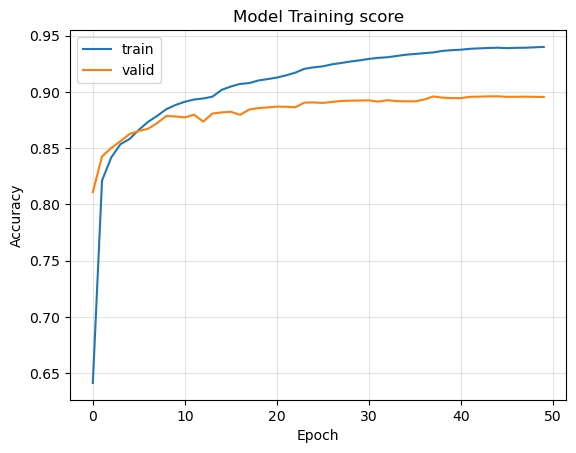

In [63]:
drawPlot()

In [64]:
class FashionModel2(nn.Module):
    def __init__(self, idim, odim):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(idim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Linear(64, 64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, odim)
        )
        
    def forward(self, x):
        return self.model(x)

In [65]:
model = FashionModel2(pixels.shape[1], len(target.unique()))

In [66]:
trainModel(model, 0.001, 50, trainDL, validDL)

Epoch [  1] ----------
Train Cost     : 0.5892946720123291
Valid Cost     : 0.5790072679519653
train Accuracy : 0.6417346596717834
valid Accuracy : 0.818142831325531
Epoch [  2] ----------
Train Cost     : 0.47465914487838745
Valid Cost     : 0.5022976398468018
train Accuracy : 0.8237755298614502
valid Accuracy : 0.8420000672340393
Epoch [  3] ----------
Train Cost     : 0.3860282599925995
Valid Cost     : 0.44641953706741333
train Accuracy : 0.84365314245224
valid Accuracy : 0.8550000190734863
Epoch [  4] ----------
Train Cost     : 0.38605865836143494
Valid Cost     : 0.44773098826408386
train Accuracy : 0.8527755737304688
valid Accuracy : 0.8584285378456116
Epoch [  5] ----------
Train Cost     : 0.3420768678188324
Valid Cost     : 0.41985249519348145
train Accuracy : 0.8627757430076599
valid Accuracy : 0.871285617351532
Epoch [  6] ----------
Train Cost     : 0.3249358832836151
Valid Cost     : 0.4148404002189636
train Accuracy : 0.8710204362869263
valid Accuracy : 0.87171429395675

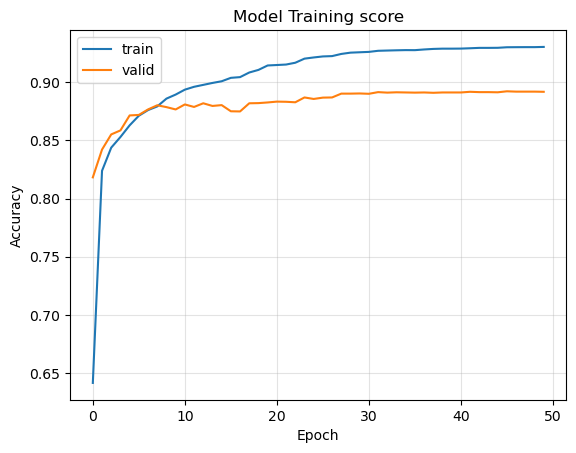

In [67]:
drawPlot()

In [68]:
class FashionModel3(nn.Module):
    def __init__(self, idim, odim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(idim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, odim)
        )

    def forward(self, x):
        return self.model(x)

In [69]:
model = FashionModel3(pixels.shape[1], len(target.unique()))

In [70]:
trainModel(model, 0.001, 50, trainDL, validDL)

Epoch [  1] ----------
Train Cost     : 0.7830405831336975
Valid Cost     : 0.7648813128471375
train Accuracy : 0.547020435333252
valid Accuracy : 0.7272856831550598
Epoch [  2] ----------
Train Cost     : 0.573406994342804
Valid Cost     : 0.6133639812469482
train Accuracy : 0.7608163952827454
valid Accuracy : 0.7984285950660706
Epoch [  3] ----------
Train Cost     : 0.4932703375816345
Valid Cost     : 0.5439968705177307
train Accuracy : 0.8061836957931519
valid Accuracy : 0.8218571543693542
Epoch [  4] ----------
Train Cost     : 0.4454362690448761
Valid Cost     : 0.50210040807724
train Accuracy : 0.8304082751274109
valid Accuracy : 0.8398571610450745
Epoch [  5] ----------
Train Cost     : 0.4101477265357971
Valid Cost     : 0.4737335443496704
train Accuracy : 0.8420001268386841
valid Accuracy : 0.8488571047782898
Epoch [  6] ----------
Train Cost     : 0.3777417838573456
Valid Cost     : 0.45034271478652954
train Accuracy : 0.8504898548126221
valid Accuracy : 0.8544285893440247
E

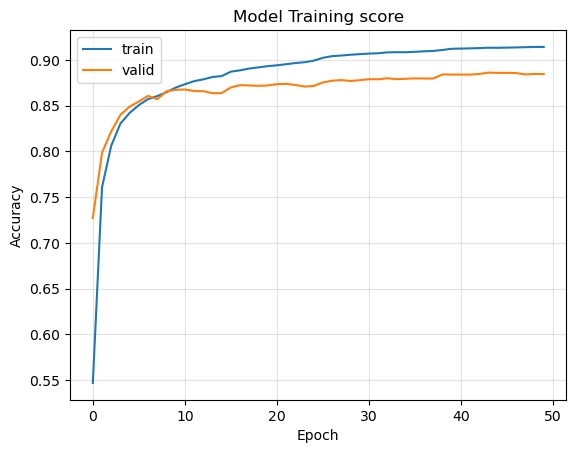

In [71]:
drawPlot()

In [72]:
class FashionModel4(nn.Module):
    def __init__(self, idim, odim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(idim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, odim)
        )

    def forward(self, x):
        return self.model(x)

In [73]:
model = FashionModel4(pixels.shape[1], len(target.unique()))

In [74]:
trainModel(model, 0.001, 50, trainDL, validDL)

Epoch [  1] ----------
Train Cost     : 0.6936887502670288
Valid Cost     : 0.6569703817367554
train Accuracy : 0.6155714988708496
valid Accuracy : 0.774142861366272
Epoch [  2] ----------
Train Cost     : 0.5003505945205688
Valid Cost     : 0.5386325120925903
train Accuracy : 0.7968571186065674
valid Accuracy : 0.8168571591377258
Epoch [  3] ----------
Train Cost     : 0.42854660749435425
Valid Cost     : 0.4915024936199188
train Accuracy : 0.8254897594451904
valid Accuracy : 0.8334285616874695
Epoch [  4] ----------
Train Cost     : 0.3903138041496277
Valid Cost     : 0.4694017171859741
train Accuracy : 0.8383877277374268
valid Accuracy : 0.8425714373588562
Epoch [  5] ----------
Train Cost     : 0.36939385533332825
Valid Cost     : 0.45363649725914
train Accuracy : 0.8481634259223938
valid Accuracy : 0.8468571305274963
Epoch [  6] ----------
Train Cost     : 0.34627190232276917
Valid Cost     : 0.4339323341846466
train Accuracy : 0.8557347655296326
valid Accuracy : 0.852428555488586